In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from encoding_information.information_estimation import *
from encoding_information.image_utils import *
from encoding_information.models.gaussian_process import *


from encoding_information.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

2023-10-26 09:12:51.424636: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-26 09:12:52.733967: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cublas/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_cupti/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvcc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvrtc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_runtime/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/pyth

Opening BSCCM
Opened BSCCM


### Generate a ground truth stationary matrix by estimating from samples

In [4]:
# Generate a ground truth covariance matrix for each channel, and then noiseless samples from it
from encoding_information.models.gaussian_process import StationaryGaussianProcess

num_images = 10000
num_patches = 10000
# num_images = 1000
# num_patches = 1000
edge_crop = 24

patch_size = 12

channel = 'DPC_Right'


images = load_bsccm_images(bsccm, channel=channel, num_images=num_images, edge_crop=edge_crop, median_filter=False)
patches = extract_patches(images, patch_size, num_patches=num_patches)

cov_mat = estimate_full_cov_mat(patches)
gp = StationaryGaussianProcess(patches)
gp.fit(patches)
true_cov_mat_px = gp.get_cov_mat()
true_mean_px = np.mean(images)

samples = gp.generate_samples(num_samples=num_patches, sample_shape=patch_size, ensure_nonnegative=True)

### Verify that mutual information estimates are consistent: they converge to the correct value given enough samples (for stationary gaussian, optimized stationary gaussian, pixelCNN)
Of course, this is on data that is sampled form a stationary gaussian process, so its only really showing that the gaussian approximation estimator can estimate gaussian entropy and MI. 


This all uses additive gaussian noise, which has an easy analytic formula for h(y | x)

In [7]:
num_val_samples

Array(2., dtype=float64, weak_type=True)

In [8]:
from encoding_information.models.gaussian_process import gaussian_likelihood

num_samples_to_use = np.array([4, 20, 100,])
num_bootstrap_samples = 10

# num_samples_to_use = np.array([4, 20, 100, 500, 2500, 5000, 10000, 20000])
# num_bootstrap_samples = 50

gaussian_sigma = 50
confidence_interval = 90

true_cov_mat_py = true_cov_mat_px + gaussian_sigma**2 * np.eye(patch_size**2)
h_y_analytic = analytic_multivariate_gaussian_entropy(true_cov_mat_py) 
# Constant conditional entropy for Gaussian noise
h_y_given_x_analytic = analytic_multivariate_gaussian_entropy(np.eye(patch_size**2) * gaussian_sigma**2) 
mi_analytic_per_pixel = (h_y_analytic - h_y_given_x_analytic) / np.log(2)

noisy_samples = add_noise(samples, gaussian_sigma=gaussian_sigma, ensure_positive=True)


stationary_mi_estimates_gp_mean = []
stationary_mi_estimates_gp_conf_int = []
stationary_mi_estimates_gp_optimized_mean = []
stationary_mi_estimates_gp_optimized_conf_int = []
stationary_mi_estimates_pixelcnn_optimized_mean = []
stationary_mi_estimates_pixelcnn_optimized_conf_int = []

ev_floor = 1e-3
for num_to_use in tqdm(num_samples_to_use):

    # estimate MI using stationary estimator
    num_val_samples = max(1, min(1000, 0.1 * num_to_use))

    mean, conf_int = run_bootstrap({'noisy_images': noisy_samples[:num_to_use], 'clean_images': samples[:num_to_use]}, 
                    num_bootstrap_samples=num_bootstrap_samples, confidence_interval=confidence_interval, estimation_fn=
                    lambda noisy_images, clean_images: estimate_mutual_information(noisy_images, clean_images, num_val_samples=num_val_samples,
                     eigenvalue_floor=ev_floor, gaussian_noise_sigma = gaussian_sigma, ) )
    stationary_mi_estimates_gp_mean.append(mean)
    stationary_mi_estimates_gp_conf_int.append(conf_int)

    mean, conf_int = run_bootstrap({'noisy_images': noisy_samples[:num_to_use], 'clean_images': samples[:num_to_use]}, 
                    num_bootstrap_samples=num_bootstrap_samples, confidence_interval=confidence_interval, estimation_fn=
                    lambda noisy_images, clean_images: estimate_mutual_information(noisy_images, clean_images, num_val_samples=num_val_samples,
                     eigenvalue_floor=ev_floor, gaussian_noise_sigma = gaussian_sigma, use_iterative_optimization=True) )
    stationary_mi_estimates_gp_optimized_mean.append(mean)
    stationary_mi_estimates_gp_optimized_conf_int.append(conf_int)

    mean, conf_int = run_bootstrap({'noisy_images': noisy_samples[:num_to_use], 'clean_images': samples[:num_to_use]},
                    num_bootstrap_samples=num_bootstrap_samples, confidence_interval=confidence_interval, estimation_fn=
                    lambda noisy_images, clean_images: estimate_mutual_information(noisy_images, clean_images, num_val_samples=num_val_samples,
                     eigenvalue_floor=ev_floor, gaussian_noise_sigma = gaussian_sigma, use_iterative_optimization=True, 
                     entropy_model='pixel_cnn') )
    stationary_mi_estimates_pixelcnn_optimized_mean.append(mean)
    stationary_mi_estimates_pixelcnn_optimized_conf_int.append(conf_int)


stationary_mi_estimates_gp_mean = np.array(stationary_mi_estimates_gp_mean)
stationary_mi_estimates_gp_conf_int = np.array(stationary_mi_estimates_gp_conf_int)
stationary_mi_estimates_gp_optimized_mean = np.array(stationary_mi_estimates_gp_optimized_mean)
stationary_mi_estimates_gp_optimized_conf_int = np.array(stationary_mi_estimates_gp_optimized_conf_int)
stationary_mi_estimates_pixelcnn_optimized_mean = np.array(stationary_mi_estimates_pixelcnn_optimized_mean)

Computing loss: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.fill_between(num_samples_to_use, stationary_mi_estimates_gp_conf_int[:,0], 
                stationary_mi_estimates_gp_conf_int[:,1], alpha=0.5, label=f'{confidence_interval}% confidence interval')
ax.fill_between(num_samples_to_use, stationary_mi_estimates_gp_optimized_conf_int[:,0],
                stationary_mi_estimates_gp_optimized_conf_int[:,1], alpha=0.5, label=f'{confidence_interval}% confidence interval')
ax.fill_between(num_samples_to_use, stationary_mi_estimates_pixelcnn_optimized_conf_int[:,0],
                stationary_mi_estimates_pixelcnn_optimized_conf_int[:,1], alpha=0.5, label=f'{confidence_interval}% confidence interval')
ax.semilogx(num_samples_to_use, stationary_mi_estimates_gp_mean, label='Estimated')
ax.semilogx(num_samples_to_use, stationary_mi_estimates_gp_optimized_mean, label='Estimated (optimized)')
ax.semilogx(num_samples_to_use, stationary_mi_estimates_pixelcnn_optimized_mean, label='Estimated (optimized, PixelCNN)')

ax.axhline(mi_analytic_per_pixel, color='k', linestyle='--', label='True')


ax.set(xlabel='Number of samples', title='stationary MI estimate\nper pixel', ylabel='bits per pixel')
clear_spines(ax)
ax.legend()


# TODO

# Same MI consistency plot, but with samples from data distrbution instead of GP
Cant show it converging to true value, but can show that it converges to a (probably biased) estimate

  0%|                                                           | 0/8 [00:00<?, ?it/s]/home/hpinkard_waller/GitRepos/EncodingInformation/gaussian_process.py:43: UserWarning: Cannot make both doubly toeplitz and positive definite. Using positive definite matrix.Smallest eigenvalue is -43553.24959347414
  warnings.warn('Cannot make both doubly toeplitz and positive definite. Using positive definite matrix.'
/home/hpinkard_waller/GitRepos/EncodingInformation/gaussian_process.py:43: UserWarning: Cannot make both doubly toeplitz and positive definite. Using positive definite matrix.Smallest eigenvalue is -9612.974022236576
  warnings.warn('Cannot make both doubly toeplitz and positive definite. Using positive definite matrix.'
/home/hpinkard_waller/GitRepos/EncodingInformation/gaussian_process.py:43: UserWarning: Cannot make both doubly toeplitz and positive definite. Using positive definite matrix.Smallest eigenvalue is -6041.934460801615
  warnings.warn('Cannot make both doubly toeplitz a

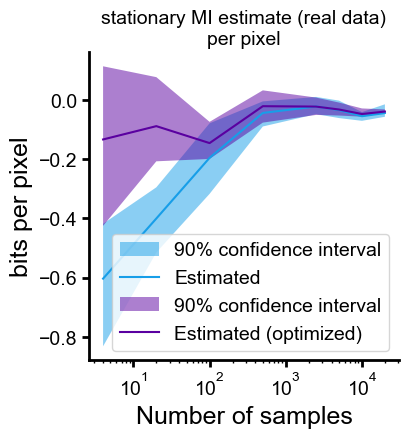

In [9]:
stationary_mi_estimates_mean = []
stationary_mi_estimates_conf_int = []
stationary_mi_estimates_optimized_mean = []
stationary_mi_estimates_optimized_conf_int = []
for num_to_use in tqdm(num_samples_to_use):
    # estimate MI using stationary estimator
    mean, conf_int = run_bootstrap(patches[:num_to_use], 
                    num_bootstrap_samples=num_bootstrap_samples, confidence_interval=confidence_interval, estimation_fn=
                    lambda noisy_images: estimate_mutual_information(noisy_images, use_stationary_model=True,
                     eigenvalue_floor=ev_floor ) )
    stationary_mi_estimates_mean.append(mean)
    stationary_mi_estimates_conf_int.append(conf_int)

    mean, conf_int = run_bootstrap(patches[:num_to_use],
                    num_bootstrap_samples=num_bootstrap_samples, confidence_interval=confidence_interval, estimation_fn=
                    lambda noisy_images: estimate_mutual_information(noisy_images, use_stationary_model=True,
                     eigenvalue_floor=ev_floor, use_iterative_optimization=True) )
    stationary_mi_estimates_optimized_mean.append(mean)
    stationary_mi_estimates_optimized_conf_int.append(conf_int)

stationary_mi_estimates_conf_int = np.array(stationary_mi_estimates_conf_int)
stationary_mi_estimates_mean = np.array(stationary_mi_estimates_mean)
stationary_mi_estimates_optimized_conf_int = np.array(stationary_mi_estimates_optimized_conf_int)
stationary_mi_estimates_optimized_mean = np.array(stationary_mi_estimates_optimized_mean)


fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.fill_between(num_samples_to_use, stationary_mi_estimates_conf_int[:,0], stationary_mi_estimates_conf_int[:,1], alpha=0.5, label=f'{confidence_interval}% confidence interval')
ax.semilogx(num_samples_to_use, stationary_mi_estimates_mean, label='Estimated')
ax.fill_between(num_samples_to_use, stationary_mi_estimates_optimized_conf_int[:,0], stationary_mi_estimates_optimized_conf_int[:,1], alpha=0.5, label=f'{confidence_interval}% confidence interval')
ax.semilogx(num_samples_to_use, stationary_mi_estimates_optimized_mean, label='Estimated (optimized)')


ax.set(xlabel='Number of samples', title='stationary MI estimate (real data)\nper pixel', ylabel='bits per pixel')
clear_spines(ax)
ax.legend()


## Estimating H(Y | X)

### Is H(Y | X) well approximated by H(Y_theoretical | Y_experimental)

#### Load images

100%|██████████████████████████████████████████████████| 3/3 [23:30<00:00, 470.14s/it]


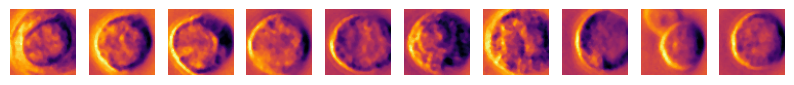

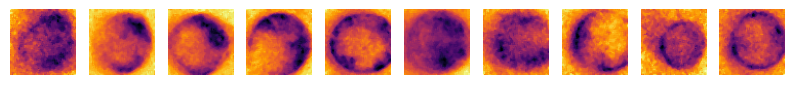

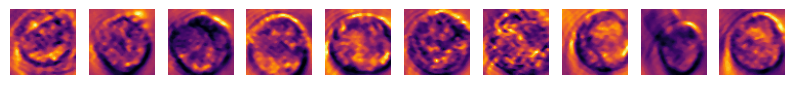

In [10]:
num_images = 10000
channels = ['DPC_Right', 'Brightfield', 'LED119']
# channels = ['LED119']

images = {}
clean_patches_by_channel = {}
for channel in tqdm(channels):
    # load "clean" median filtered images
    images[channel] = load_bsccm_images(bsccm, channel=channel, num_images=num_images, edge_crop=32, median_filter=True)        
    clean_patches_by_channel[channel] = extract_patches(images[channel], patch_size, num_patches=num_patches)

    # plot a montage of images
    num_to_plot = 10
    fig, ax = plt.subplots(1, num_to_plot, figsize=(num_to_plot, 1))
    for i in range(num_to_plot):
        ax[i].imshow(images[channel][i], cmap='inferno')
        ax[i].axis('off')

#### Compare conditional entropy of noisy to clean

In [11]:
mean_photons = {channel: np.mean(images[channel]) for channel in images.keys()}
photons_per_pixel_list = [5, 10, 20, 40, 80, 160, 320]
num_bootstraps = 10
patch_size = 15
num_patches = 10000
confidence_interval = 99

results = {}
for channel in channels:
    results[channel] = []
    for photons_per_pixel in tqdm(photons_per_pixel_list):
        rescale_fractions = {channel: photons_per_pixel / mean_photons[channel] for channel in images.keys()}
        clean_patches = clean_patches_by_channel[channel] * rescale_fractions[channel]
        noisy_patches = add_noise(clean_patches, ensure_positive=True)

        noisy_conditional_mean, noisy_conditional_interval = run_bootstrap(noisy_patches, num_bootstrap_samples=num_bootstraps, confidence_interval=confidence_interval, estimation_fn=
                                                             lambda noisy_images: estimate_mutual_information(noisy_images=noisy_images, verbose=False))
        clean_conditional_mean, clean_conditional_interval = run_bootstrap({'clean_images': clean_patches, 'noisy_images': noisy_patches},
                                                                            num_bootstrap_samples=num_bootstraps, confidence_interval=confidence_interval, estimation_fn=
                                                                lambda noisy_images, clean_images: estimate_mutual_information(noisy_images=noisy_images, clean_images=clean_images, verbose=False))
        results[channel].append((noisy_conditional_mean, noisy_conditional_interval, clean_conditional_mean, clean_conditional_interval))
        

  0%|                                                           | 0/7 [00:00<?, ?it/s]/home/hpinkard_waller/GitRepos/EncodingInformation/information_estimation.py:232: UserWarning: Mean pixel value is 4.95. More accurate results can probably be obtainedby setting estimate_conditional_from_model_samples=True
  warnings.warn(f"Mean pixel value is {np.mean(clean_images_if_available):.2f}. More accurate results can probably be obtained"
/home/hpinkard_waller/GitRepos/EncodingInformation/information_estimation.py:232: UserWarning: Mean pixel value is 4.96. More accurate results can probably be obtainedby setting estimate_conditional_from_model_samples=True
  warnings.warn(f"Mean pixel value is {np.mean(clean_images_if_available):.2f}. More accurate results can probably be obtained"
 14%|███████▎                                           | 1/7 [00:04<00:27,  4.63s/it]/home/hpinkard_waller/GitRepos/EncodingInformation/information_estimation.py:232: UserWarning: Mean pixel value is 9.91. More 

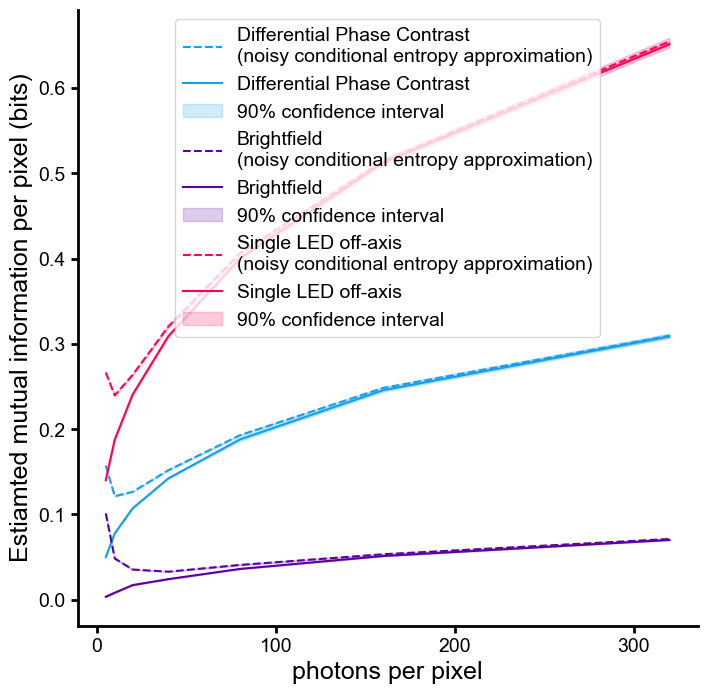

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
colors = get_color_cycle()
for color, (channel, channel_results) in zip(colors, results.items()):
    noisy_conditional_means = []
    noisy_conditional_intervals = []
    clean_conditional_means = []
    clean_conditional_intervals = []
    for noisy_conditional_mean, noisy_conditional_interval, clean_conditional_mean, clean_conditional_interval in channel_results:
        noisy_conditional_means.append(noisy_conditional_mean)
        noisy_conditional_intervals.append(noisy_conditional_interval)
        clean_conditional_means.append(clean_conditional_mean)
        clean_conditional_intervals.append(clean_conditional_interval)
    noisy_conditional_means = np.array(noisy_conditional_means)
    noisy_conditional_intervals = np.array(noisy_conditional_intervals)
    clean_conditional_means = np.array(clean_conditional_means)
    clean_conditional_intervals = np.array(clean_conditional_intervals)
    
    channel_name = get_display_channel_names(channel)
    ax.plot(photons_per_pixel_list, noisy_conditional_means, '--',label=channel_name + '\n(noisy conditional entropy approximation)', color=color)
    ax.fill_between(photons_per_pixel_list, noisy_conditional_intervals[:, 0], noisy_conditional_intervals[:, 1], alpha=0.2, 
                    color=color)
                    #   hatch='x',)
    ax.plot(photons_per_pixel_list, clean_conditional_means, '-', label=channel_name , color=color)
    ax.fill_between(photons_per_pixel_list, clean_conditional_intervals[:, 0], clean_conditional_intervals[:, 1], alpha=0.2, 
                    color=color, label=f'{confidence_interval}% confidence interval', )
                    # hatch='.')
    ax.set(xticks=[0, 100, 200, 300])

clear_spines(ax)
ax.set(xlabel='photons per pixel', ylabel='Estiamted mutual information per pixel (bits)')
ax.legend()